### Import the packages

In [61]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter

sns.set_style('whitegrid')

### Load dataset

In [63]:
# define column names for easy indexing
index_names = ['unit_num', 'time_cycles']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names = ['sensor{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('../data/train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('../data/test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('../data/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# inspect first few rows
train.head()

,unit_num,time_cycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Exploratory data analysis

In [64]:
train.unit_num.unique().shape

(100,)

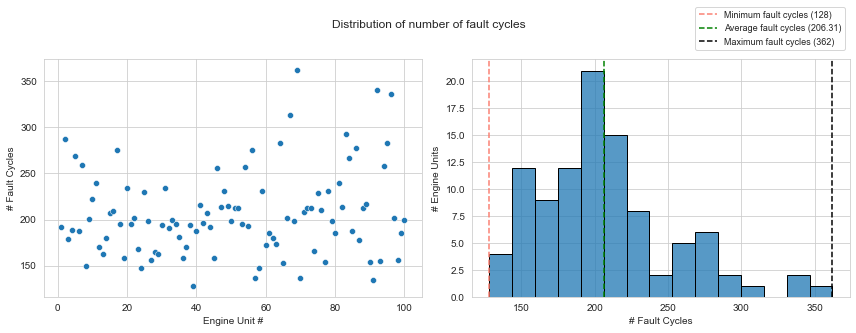

In [65]:
n_cycles = train[index_names].groupby('unit_num').count()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=n_cycles, x="unit_num", y="time_cycles", ax=axes[0])

hist = sns.histplot(data=n_cycles, x="time_cycles", edgecolor='k', ax=axes[1], bins=15)
hist.axvline(n_cycles.time_cycles.min(), color="salmon",
             label=f"Minimum fault cycles ({n_cycles.time_cycles.min()})", ls="--")
hist.axvline(n_cycles.time_cycles.mean(), color="green",
             label=f"Average fault cycles ({round(n_cycles.time_cycles.mean(), 2)})", ls="--")
hist.axvline(n_cycles.time_cycles.max(), color="black",
             label=f"Maximum fault cycles ({n_cycles.time_cycles.max()})", ls="--")

axes[0].set_ylabel("# Fault Cycles")
axes[0].set_xlabel("Engine Unit #")

axes[1].set_ylabel("# Engine Units")
axes[1].set_xlabel("# Fault Cycles")

plt.tight_layout()

axes[1].legend(ncol=1, loc="upper right", bbox_to_anchor=[1, 1.24], fontsize=9)
fig.suptitle("Distribution of number of fault cycles", y=1.1)

plt.show()

**Most engines break down around 200 cycles and very few engines last over 300 cycles.**

**We'll assume that the RUL decreases linearly over time and have a value of 0 at the last time cycle of the engine. This assumption implies RUL would be 10 at 10 cycles before breakdown, 50 at 50 cycles before breakdown, etc.**

In [66]:
def add_remaining_useful_life(df):
    
    result_frame = df.merge(n_cycles.rename(columns={"time_cycles": "n_cycles"}),
                            left_on='unit_num', right_index=True)
    remaining_useful_life = result_frame["n_cycles"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    result_frame = result_frame.drop("n_cycles", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names + ['RUL']].head()

,unit_num,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [67]:
min_rul = train.RUL.min()
max_rul = train.RUL.max()

**Check the distribution of RULs for train and test sets**

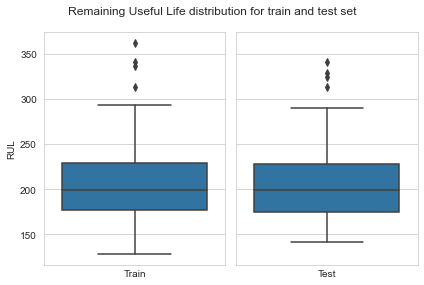

In [68]:
train_rul = n_cycles.time_cycles.values

# Test set overall RUL is sum of remaining cycles plus the number of cycles a machine has already ran
test_rul = test.groupby('unit_num').count().time_cycles.values + y_test.RUL.values

fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)

sns.boxplot(data=train_rul, ax=axes[0])
sns.boxplot(data=test_rul, ax=axes[1])

axes[0].set_ylabel("RUL")
axes[0].set_xlabel("Train")
axes[0].set_xticks(ticks=[])

axes[1].set_xlabel("Test")
axes[1].set_xticks(ticks=[])

fig.suptitle("Remaining Useful Life distribution for train and test set")
plt.tight_layout()

plt.show()

**Distribution is quite similar for both sets**

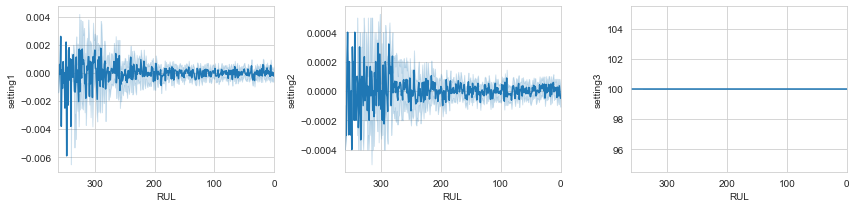

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for i, s in enumerate(setting_names):
    sns.lineplot(data=train, x="RUL", y=s, ax=axes[i])
    axes[i].set_xlim(max_rul, min_rul)

plt.tight_layout()
plt.show()

**Fluctuations gradually decrease in setting 1 and 2 as RUL decrease. Setting 3 doesn't change at all. All three columns can be discarded since they aren't telling us anything as the machine reaches its end-of-life.**

In [70]:
del_cols = ["setting1", "setting2", "setting3"]

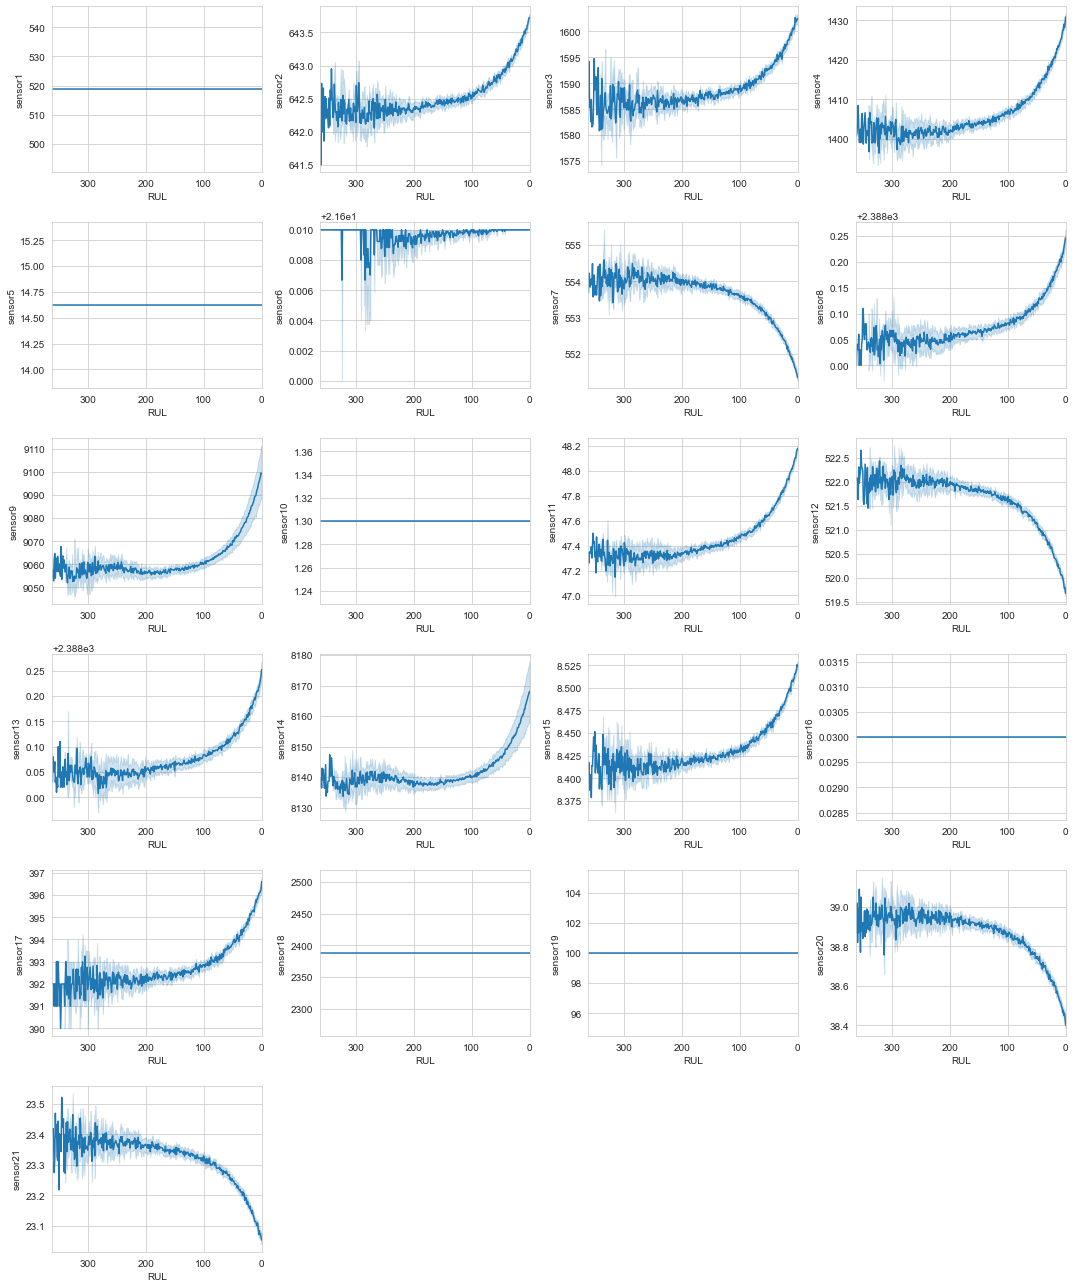

In [71]:
sensor_names = [f"sensor{i+1}" for i in range(21)]

fig, axes = plt.subplots(6, 4, figsize=(15, 18))

for i, s in enumerate(sensor_names):
    sns.lineplot(data=train, x="RUL", y=s, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_xlim(max_rul, min_rul)

axes.flat[-3].set_visible(False)
axes.flat[-2].set_visible(False)
axes.flat[-1].set_visible(False)
plt.tight_layout()
plt.show()

**Sensors 1, 5, 10, 16, 18 and 19 are constant. These can be dropped.**

In [72]:
del_cols += ["sensor1", "sensor5", "sensor10", "sensor16", "sensor18", "sensor19"]

**Sensor 6 stops changing as RUL decreases. It can be dropped as well.**

In [73]:
del_cols.append("sensor6")

**Sensor 9 and 14 have plots almost identical, could they be correlated with each other?**

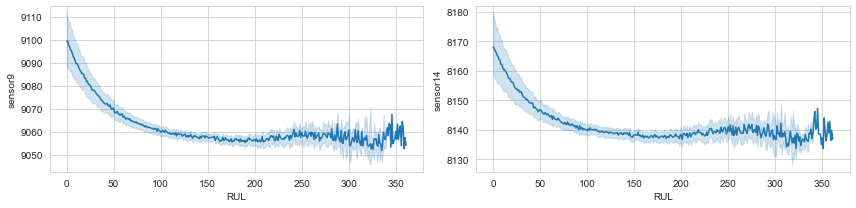

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

sns.lineplot(data=train, x="RUL", y="sensor9", ax=axes[0])
sns.lineplot(data=train, x="RUL", y="sensor14", ax=axes[1])

plt.tight_layout()

plt.show()

In [75]:
train[["sensor9", "sensor14"]].corr()

,sensor9,sensor14
sensor9,1.000000,0.963157
sensor14,0.963157,1.000000


**96% correlations. We can drop any one of them.**

In [76]:
del_cols.append("sensor14")

<b>Sensors 2, 3, 4, 8, 9, 11, 13, 15, and 17 shows increasing trend which means as the engine nears towards its end life, values of these sensors increase. Opposite is true for the sensors 7, 12, 20, and 21 which show decreasing trend.</b>

### Process and standardize train-test splits

In [77]:
del_cols += index_names

X_train = train.drop(del_cols, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_num').last().reset_index().drop(del_cols, axis=1)

scaler = StandardScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

X_train.shape, X_test.shape

((20631, 13), (100, 13))

### Build baseline models

In [78]:
def get_metrics(y, p, label):
    mae = mean_absolute_error(y, p)
    rmse = mean_squared_error(y, p, squared=False)
    r2 = r2_score(y, p)
    print(f'----- {label} -----\nRMSE: {round(rmse, 2)}\nMAE : {round(mae, 2)}\nR2  : {round(r2, 2)}\n')

In [79]:
def train_and_plot(model, X_train, y_train, X_test, y_test, plot):
    model = deepcopy(model)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    get_metrics(y_train, y_pred_train, "Train")

    y_pred_test = model.predict(X_test)
    get_metrics(y_test, y_pred_test, "Test")
    
    if plot:
        plt.figure(figsize=(5, 5))

        sns.regplot(x=y_test.RUL.values, y=y_pred_test, color='red', label="Linear fit")
        sns.scatterplot(x=y_test.RUL.values, y=y_pred_test, edgecolor='k')

        plt.xlabel("Actual RUL")
        plt.ylabel("Predicted RUL")
        plt.title("Actual vs predicted RUL for test set")

        plt.show()
    
    return model

**Linear Regression**

----- Train -----
RMSE: 44.69
MAE : 34.13
R2  : 0.58

----- Test -----
RMSE: 32.2
MAE : 25.64
R2  : 0.4



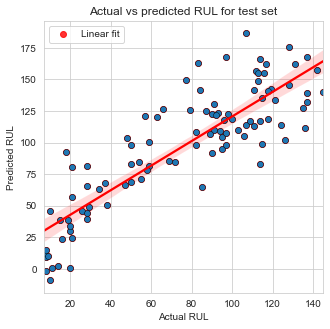

In [80]:
lm = LinearRegression()
lm = train_and_plot(lm, X_train, y_train, X_test, y_test, plot=True)

**Random Forest**

----- Train -----
RMSE: 36.8
MAE : 25.81
R2  : 0.71

----- Test -----
RMSE: 32.33
MAE : 23.98
R2  : 0.39



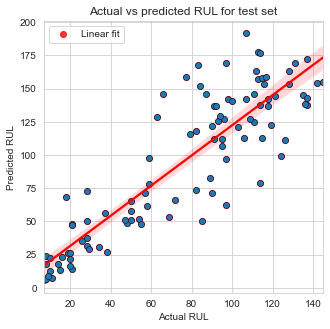

In [81]:
rf = RandomForestRegressor(max_depth=10, random_state=42, n_jobs=15)
rf = train_and_plot(rf, X_train, y_train, X_test, y_test, plot=True)

### Improve baseline models

**One big assumption we made is that RUL decreases linearly over time. Let's revisit that assumption. We see that, in many sensors, the values are often constant initially and there's sudden rise or fall in the values. This makes sense since the engines only develop a fault over time. The bend in the curve of the signal is the first bit of information provided to us that the engine is degrading and the first time it is reasonable to assume RUL is linearly declining. We can’t really say anything about the RUL before that point because we have no information about the initial wear and tear.**

**Therefore, we can update our assumption to reflect this logic. Instead of having our RUL decline linearly, we define our RUL to start out as a constant and only decline linearly after some time. By doing so we achieve two things:**<br><br>

<b>
    <ol>
        <li>Initially constant RUL correlates better with the initially constant mean sensor signal</li>
        <li>Lower peak values for RUL result in lower spread of our target variable, making it easier to fit a line</li>
    </ol>
</b>

In [82]:
y_train_clipped = y_train.clip(upper=125)  # 125 chose after some manual analysis

----- Train -----
RMSE: 21.52
MAE : 17.61
R2  : 0.73

----- Test -----
RMSE: 22.07
MAE : 17.79
R2  : 0.72



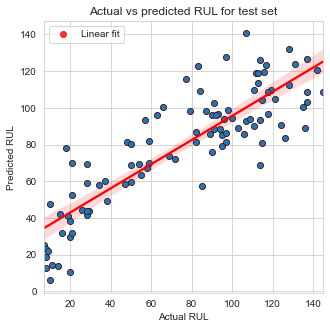

In [83]:
lm = LinearRegression()
lm = train_and_plot(lm, X_train, y_train_clipped, X_test, y_test, plot=True)

----- Train -----
RMSE: 17.16
MAE : 12.64
R2  : 0.83

----- Test -----
RMSE: 18.53
MAE : 13.64
R2  : 0.8



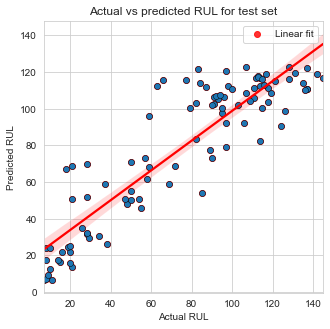

In [84]:
rf = RandomForestRegressor(max_depth=8, random_state=42, n_jobs=15)
rf = train_and_plot(rf, X_train, y_train_clipped, X_test, y_test, plot=True)

**This time both RMSE and R<sup>2</sup> improved significantly. RMSE shows an 42% decrease while R<sup>2</sup> increased by 105%. So we're on the right track. Let's check the feature importance score for the model.**

In [85]:
!python --version

Python 3.8.5


In [98]:
X_train.columns

Index(['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9',
       'sensor11', 'sensor12', 'sensor13', 'sensor15', 'sensor17', 'sensor20',
       'sensor21'],
      dtype='object')

In [99]:
cols =X_train.columns.tolist()


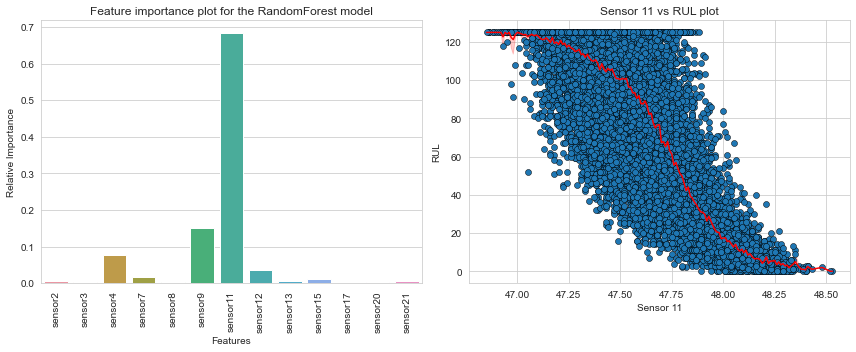

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=cols, y=rf.feature_importances_, ax=axes[0])
sns.lineplot(x=train["sensor11"], y=y_train_clipped, color='red', ax=axes[1])
sns.scatterplot(x=train["sensor11"], y=y_train_clipped, edgecolor='k', ax=axes[1])

axes[0].tick_params('x', labelrotation=90)
axes[0].set_xlabel("Features")
axes[0].set_ylabel("Relative Importance")
axes[0].set_title("Feature importance plot for the RandomForest model")

axes[1].set_xlabel("Sensor 11")
axes[1].set_ylabel("RUL")
axes[1].set_title("Sensor 11 vs RUL plot")

plt.tight_layout()
plt.show()

**The left plot shows Sensor 11 to be highly important. The right plot shows a strong decreasing trend for Sensor 11 with RUL.**

### Survival Analysis

In [ ]:
train2 = train.copy()
train2['RUL'] = train2['RUL'].clip(upper=125)  

train2.drop(del_cols[:-2], axis=1, inplace=True)
train2 = train2.reset_index(drop=True)

remaining_sensors = list(train2.columns)[2:-1]

**Add an event column**

In [ ]:
train2['breakdown'] = 0

idx_last_record = train2.reset_index().groupby(by='unit_num')['index'].last()  # engines breakdown at the last cycle
train2.loc[idx_last_record, 'breakdown'] = 1

**Indicate the start and stop times of each observation**

In [ ]:
train2['start'] = train2['time_cycles'] - 1 
train2.tail()

**In the train set each engine is run to failure, therefore there aren’t any censored observations. We’ll artificially right-censor our dataset by disregarding any records after 200 time_cycles. This allows us to play around with the data in a bit more realistic setting, with a mix of engines which did and did not have their breakdown yet.**

In [ ]:
cut_off = 200
train_censored = train2[train2.time_cycles <= cut_off].copy()

**KaplanMeier curve**

In [ ]:
data = train_censored[index_names + ['breakdown']].groupby('unit_num').last()

plt.figure(figsize=(12, 5))

survival = KaplanMeierFitter()
survival.fit(data['time_cycles'], data['breakdown'])
survival.plot()

plt.ylabel("Probability of survival")
plt.show()

**100% probability of engine surviving before 128 cycles as expected since none of the engines broke down before that. There's also a ~45% probability of surviving past 200 cycles.**

#### Cox Proportional Hazards models

In [ ]:
# remaining_sensors.remove("sensor8")
# remaining_sensors.remove("sensor15")
# remaining_sensors.remove("sensor3")
# remaining_sensors.remove("sensor21")

In [ ]:
train_cols = index_names + remaining_sensors + ['start', 'breakdown']
predict_cols = ['time_cycles'] + remaining_sensors + ['start', 'breakdown']  # breakdown value will be 0

ctv = CoxTimeVaryingFitter()
_ = ctv.fit(train_censored[train_cols], id_col="unit_num", event_col='breakdown', 
            start_col='start', stop_col='time_cycles', show_progress=True, fit_options={"step_size": 1})

In [ ]:
ctv.print_summary()

plt.figure(figsize=(10, 5))
ctv.plot()

plt.show()

**Sensor 8 and 15 have large p-values**

In [ ]:
df1 = train_censored.groupby("unit_num").last()
df1 = df1[df1['breakdown'] == 0]  # get engines from dataset which are still functioning so we can predict their RUL
df_to_predict = df1[df1['breakdown'] == 0].copy()

predictions = ctv.predict_log_partial_hazard(df_to_predict[predict_cols])
predictions = pd.DataFrame(predictions, columns=["predictions"])

df_last = train.groupby('unit_num').last()
predictions['RUL'] = df_to_predict['RUL'].values
predictions.head(10)

In [ ]:
plt.figure(figsize=(12, 5))

sns.scatterplot(x=predictions['RUL'], y=predictions['predictions'])

xlim = plt.gca().get_xlim()
plt.xlim(xlim[1], xlim[0])
plt.xlabel('RUL')
plt.ylabel('log_partial_hazard')

plt.show()

In [ ]:
from scipy.optimize import curve_fit

def exponential_model(z, a, b):
    return a * np.exp(-b * z)

In [ ]:
ctv2 = CoxTimeVaryingFitter()
ctv2.fit(train2[train_cols], id_col="unit_num", event_col='breakdown', 
        start_col='start', stop_col='time_cycles', show_progress=False)

train2['hazard'] = ctv2.predict_log_partial_hazard(train2)
popt2, pcov2 = curve_fit(exponential_model, train2['hazard'], train2['RUL'])

y_hat = exponential_model(train2['hazard'], *popt2)
get_metrics(train2['RUL'], y_hat, 'Train')

y_pred = ctv2.predict_log_partial_hazard(test.groupby('unit_num').last())
y_hat = exponential_model(y_pred, *popt2)
get_metrics(y_test, y_hat, "Test")